# dAiv AI_Competition[2024]_Basic Baseline for PyTorch

## Import Libraries

In [1]:
from os import path, mkdir

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import torchvision
import torchvision.models
from torchvision import transforms

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

### Check GPU Availability

In [2]:
!nvidia-smi

Wed Aug  7 15:17:31 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.29.05    Driver Version: 495.29.05    CUDA Version: 11.5     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  On   | 00000000:04:00.0 Off |                    0 |
| N/A   41C    P0    34W / 250W |   5661MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   

In [3]:
# Set CUDA Device Number 0~7
DEVICE_NUM = 6

device = torch.device("cpu")
if torch.cuda.is_available():
    torch.cuda.set_device(DEVICE_NUM)
    device = torch.device("cuda")
print("INFO: Using device -", device)

INFO: Using device - cuda


## Load DataSets

In [4]:
from typing import Callable, Optional
from torchvision.datasets.utils import download_and_extract_archive

torchvision.datasets.utils.tqdm = tqdm


class FoodImageDataset(torchvision.datasets.ImageFolder):
    download_url = "https://daiv-cnu.duckdns.org/contest/ai_competition[2024]_basic/dataset/datasets.zip"

    def __init__(self, root: str, force_download: bool = True, train: bool = True, valid: bool = False, transform: Optional[Callable] = None, target_transform: Optional[Callable] = None):
        self.download(root, force=force_download)

        if train:
            if valid:
                root = path.join(root, "valid")
            else:
                root = path.join(root, "train")
        else:
            root = path.join(root, "test")

        super().__init__(root=root, transform=transform, target_transform=target_transform)

    @classmethod
    def download(cls, root: str, force: bool = False):
        if force or not path.isfile(path.join(root, "datasets.zip")):
            download_and_extract_archive(cls.download_url, download_root=root, extract_root=root, filename="datasets.zip")
            print("INFO: Dataset archive downloaded and extracted.")
        else:
            print("INFO: Dataset archive found in the root directory. Skipping download.")

In [5]:
# Image Resizing and Tensor Conversion
IMG_SIZE = (512, 512)
IMG_NORM = dict(  # ImageNet Normalization
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
)

resizer = transforms.Compose([
    transforms.Resize(IMG_SIZE),  # Resize Image
    transforms.ToTensor(),  # Convert Image to Tensor
    transforms.Normalize(**IMG_NORM)  # Normalization
])

In [6]:
DATA_ROOT = path.join(".", "data")

train_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, train=True, transform=resizer)
valid_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, valid=True, transform=resizer)
test_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, train=False, transform=resizer)

print(f"INFO: Dataset loaded successfully. Number of samples - Train({len(train_dataset)}), Valid({len(valid_dataset)}), Test({len(test_dataset)})")

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset archive found in the root directory. Skipping download.
INFO: Dataset loaded successfully. Number of samples - Train(9866), Valid(3430), Test(3347)


## Data Augmentation if needed

In [7]:
ROTATE_ANGLE = 20
COLOR_TRANSFORM = 0.1

In [8]:
augmenter = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(ROTATE_ANGLE),
    transforms.ColorJitter(
        brightness=COLOR_TRANSFORM, contrast=COLOR_TRANSFORM,
        saturation=COLOR_TRANSFORM, hue=COLOR_TRANSFORM
    ),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0), ratio=(0.75, 1.333)),
    resizer
])

In [9]:
train_dataset = FoodImageDataset(root=DATA_ROOT, force_download=False, train=True, transform=augmenter)

print(f"INFO: Train dataset has been overridden with augmented state. Number of samples - Train({len(train_dataset)})")

INFO: Dataset archive found in the root directory. Skipping download.
INFO: Train dataset has been overridden with augmented state. Number of samples - Train(9866)


## DataLoader

In [10]:
# Set Batch Size
BATCH_SIZE = 64

In [11]:
MULTI_PROCESSING = True  # Set False if DataLoader is causing issues

from platform import system
if MULTI_PROCESSING and system() != "Windows":  # Multiprocess data loading is not supported on Windows
    import multiprocessing
    cpu_cores = multiprocessing.cpu_count()
    print(f"INFO: Number of CPU cores - {cpu_cores}")
else:
    cpu_cores = 0
    print("INFO: Using DataLoader without multi-processing.")

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=cpu_cores)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_cores)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=cpu_cores)

INFO: Number of CPU cores - 48


## Define Model

### 0. BaselineModel

In [15]:
class ImageClassifier(nn.Module):
    def __init__(self, input_channel: int, output_channel: int, img_size: int, num_classes: int):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=input_channel, out_channels=output_channel//4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=output_channel//4, out_channels=output_channel//2, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels=output_channel//2, out_channels=output_channel, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # Assuming you want to connect to a fully connected layer after flattening
        # Calculate the size of the flattened features after 3 pooling layers
        self.fc_size = output_channel * (img_size // 2**3) * (img_size // 2**3)
        self.fc = nn.Linear(self.fc_size, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)  # Flatten the output for the fully connected layer
        out = self.fc(out)
        return out

### 1. ResNetWithAttention

In [12]:
class SelfAttention(nn.Module):
    def __init__(self, in_dim):
        super(SelfAttention, self).__init__()
        self.query_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.key_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim // 8, kernel_size=1)
        self.value_conv = nn.Conv2d(in_channels=in_dim, out_channels=in_dim, kernel_size=1)
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        batch_size, C, width, height = x.size()
        
        # Query, Key, Value 계산
        query = self.query_conv(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        key = self.key_conv(x).view(batch_size, -1, width * height)
        energy = torch.bmm(query, key)  # [B, N, N]
        
        # Attention 계산
        attention = self.softmax(energy)
        
        # Value 계산
        value = self.value_conv(x).view(batch_size, -1, width * height)
        out = torch.bmm(value, attention.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)
        
        # Attention 결과와 입력을 결합
        out = self.gamma * out + x
        return out

In [15]:
class ResNetImageClassifierWithAttention(nn.Module):
    def __init__(self, num_classes: int):
        super(ResNetImageClassifierWithAttention, self).__init__()
        
        # ResNet18 모델 불러오기 (사전 학습된 모델을 사용하지 않음)
        self.resnet = torchvision.models.resnet18(pretrained=False)
        
        # ResNet에서 Feature Extractor로 사용할 레이어 (Pooling 전까지)
        self.features = nn.Sequential(*list(self.resnet.children())[:-2])
        
        # Attention Layer 추가
        self.attention = SelfAttention(in_dim=512)  # ResNet18의 마지막 레이어 채널 수는 512
        
        # Adaptive Average Pooling과 Fully Connected Layer
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        # Feature Extraction
        x = self.features(x)
        
        # Attention 적용
        x = self.attention(x)
        
        # Global Average Pooling
        x = self.avg_pool(x)
        
        # Flatten 후 Classification
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

### 2. ResNet

In [16]:
class ResNetImageClassifier(nn.Module):
    def __init__(self, num_classes: int):
        super(ResNetImageClassifier, self).__init__()
        
        # Pretrained ResNet 모델 불러오기 (여기서는 ResNet18 사용)
        self.resnet = torchvision.models.resnet18(pretrained=False)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        return x

In [17]:
CLASS_LABELS = len(train_dataset.classes)

MODEL_PARAMS = dict(
    input_channel=3, output_channel=64,
    img_size=IMG_SIZE[0], num_classes=CLASS_LABELS
)

In [18]:
# Initialize Model
model = ResNetImageClassifierWithAttention(num_classes=CLASS_LABELS)
model.to(device)

/home/shinhaesol11/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shinhaesol11/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNetImageClassifierWithAttention(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0

In [38]:
LEARNING_RATE = 1e-6

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE)

## Training Loop

In [39]:
# Set Epoch Count
num_epochs = 100

Running Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/155 [00:00<?, ?it/s]

Validation:   0%|          | 0/54 [00:00<?, ?it/s]

Output()

Epoch [ 1/100], Step [155/155], Loss: 0.803092, Valid Acc: 70.145762%, Valid Loss: 0.910117

Epoch [ 2/100], Step [155/155], Loss: 1.090525, Valid Acc: 70.408142%, Valid Loss: 0.902009

Epoch [ 3/100], Step [155/155], Loss: 0.709812, Valid Acc: 70.320690%, Valid Loss: 0.904027

KeyboardInterrupt: 

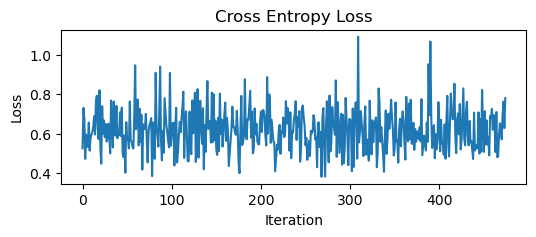

In [40]:
train_length, valid_length = map(len, (train_loader, valid_loader))

epochs = tqdm(range(num_epochs), desc="Running Epochs")
with (tqdm(total=train_length, desc="Training") as train_progress,
        tqdm(total=valid_length, desc="Validation") as valid_progress):  # Set up Progress Bars
    update = create_plot()  # Create Loss Plot

    for epoch in epochs:
        train_progress.reset(total=train_length)
        valid_progress.reset(total=valid_length)

        # Training
        model.train()
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()

            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            update(loss)
            train_progress.update(1)

        val_acc, val_loss = 0, 0

        # Validation
        model.eval()
        with torch.no_grad():
            for inputs, targets in valid_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)

                val_loss += criterion(outputs, targets).item() / valid_length
                val_acc += (torch.max(outputs, 1)[1] == targets.data).sum() / len(valid_dataset)
                valid_progress.update(1)

        print(f"\rEpoch [{epoch+1:2}/{num_epochs}], Step [{train_length}/{train_length}], Loss: {loss.item():.6f}, Valid Acc: {val_acc:.6%}, Valid Loss: {val_loss:.6f}", end="\n" if (epoch+1) % 5 == 0 or (epoch+1) == num_epochs else "")

In [33]:
if not path.isdir(path.join(".", "models")):
    import os
    os.mkdir(path.join(".", "models"))

model_id = "resnet_with_attention_augmented"
save_path = path.join(".", "models", f"{model_id}.pt")
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to ./models/resnet_with_attention_augmented.pt


# Model Evaluation

In [34]:
# Load Model
model = ResNetImageClassifierWithAttention(num_classes=CLASS_LABELS)
model.load_state_dict(torch.load(path.join(".", "models", f"{model_id}.pt")))
model.to(device)

/home/shinhaesol11/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shinhaesol11/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ResNetImageClassifierWithAttention(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0

In [35]:
results = dict(id=[], label=[])
test_length = len(test_dataset)

model.eval()
with torch.no_grad():
    for inputs, ids in tqdm(test_loader):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        results['id'] += [test_dataset.classes[i] for i in ids]
        results['label'] += [train_dataset.classes[i] for i in preds.cpu().detach().numpy().tolist()]

  0%|          | 0/53 [00:00<?, ?it/s]

In [36]:
from datetime import datetime
import pytz

seoul_timezone = pytz.timezone('Asia/Seoul')
seoul_time = datetime.now(seoul_timezone)
curr_time = seoul_time.strftime(r'%m%d%H%M')

In [37]:
# Save Results
results_df = pd.DataFrame(results)

submission_dir = "submissions"
if not path.isdir(submission_dir):
    mkdir(submission_dir)

submit_file_path = path.join(submission_dir, f"{model_id}_{curr_time}.csv")
results_df.to_csv(submit_file_path, index=False)
print("File saved to", submit_file_path)

results_df.head()

File saved to submissions/resnet_with_attention_augmented_08_08_10_52.csv


,id,label
0,TEST_0000,Dessert
1,TEST_0001,Dairy product
2,TEST_0002,Seafood
3,TEST_0003,Meat
4,TEST_0004,Soup
